In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline
pd.plotting.register_matplotlib_converters()
plt.style.use('ggplot')

In [2]:
# MARTS data
marts = pd.read_csv('marts.csv')
marts = marts.set_index(pd.to_datetime(marts['date'])).drop('date', axis=1)

In [3]:
# Seasonal adjustment
sa = pd.read_csv('seas_adj.csv').set_index('Sector')
march_sa = sa['2020-03-31']

In [4]:
# Signal data
daily_metrics = pd.read_csv(
    'daily_metrics.csv', 
    dtype={'MCC_CDE': str, 'NET_AMT': np.float64, 'CARD_CNT': np.int64, 'TXN_CNT': np.int64}
)

daily_metrics.columns = map(str.lower, daily_metrics.columns)
daily_metrics = daily_metrics.set_index(pd.to_datetime(daily_metrics['txn_date'])).drop('txn_date', axis=1)
daily_metrics = daily_metrics.sort_index()
daily_metrics

,mcc_cde,net_amt,card_cnt,txn_cnt
txn_date,,,,
2015-01-01,8011,207285.63,3415,3739
2015-01-01,6513,548620.57,1206,1376
2015-01-01,3727,1175.98,5,6
2015-01-01,3650,8316.77,89,99
2015-01-01,3708,351.92,5,6
...,...,...,...,...
2020-04-02,5169,150459.23,662,758
2020-04-02,4511,23203.75,116,144
2020-04-02,6321,20267.12,89,99


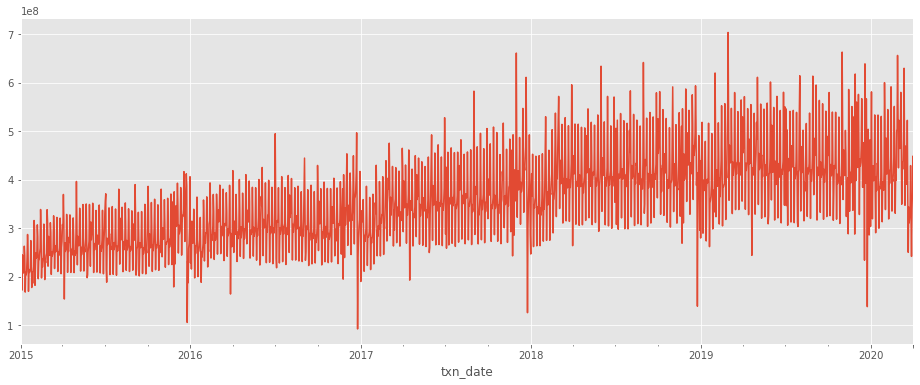

In [5]:
daily_metrics['net_amt'].groupby('txn_date').sum().plot(figsize=(16,6))

In [6]:
def rolling_mean(df, start_date, end_date, feature, n=7):
    data_start_date = pd.to_datetime(start_date) + n*pd.Timedelta('-1d')
    rm = df[feature].loc[data_start_date:end_date].groupby('txn_date').sum().rolling(n).mean().loc[start_date:end_date]
    return rm

In [7]:
def extract_ytd_rolling_mean_comps(df, feature):
    data_2019 = rolling_mean(df, '2019-01-01', '2019-04-02', feature, n=7)
    data_2020 = rolling_mean(df, '2020-01-01', '2020-04-01', feature, n=7)
    data_2019.index = data_2020.index
    return data_2019, data_2020

In [8]:
def plot_yoy_comp(data_2019, data_2020, title):
    fig, axes = plt.subplots(2, 1, figsize=(16,10))
    ax1, ax2 = axes
    fig.suptitle(title)

    ax1.plot(data_2019, label='2019')
    ax1.plot(data_2020, label='2020')
    ax1.legend()
    ax1.set_title('Absolute levels')

    ax2.plot(data_2020/data_2019)
    ax2.set_title('2020 / 2019 levels')

In [9]:
def resample_monthly(df, feature):
    return df.resample('1M')[feature].sum().iloc[:-1] # Cut off April

In [10]:
def yoy_monthly_chg(df, feature):
    return resample_monthly(df, feature).pct_change(12).dropna()

In [11]:
def align_marts_with_feature_yoy_chg(marts, category, df, feature):
    return pd.DataFrame([marts[category].pct_change(12), yoy_monthly_chg(df, feature)]).T.dropna(subset=[feature])

In [12]:
def predict_month(marts, category, yoy, feature, date):
    year_ago = (pd.to_datetime(date) + pd.offsets.MonthEnd(-12)).strftime('%Y-%m-%d')
    return (1 + yoy.loc[date, feature]) * marts.loc[year_ago, category]

In [13]:
def plot_prediction(marts, category, yoy, feature, date):
    next_month = predict_month(marts, category, yoy, feature, date)
    prediction = marts[category].copy()
    prediction.loc[date] = next_month
    prediction.plot(figsize=(16,6))

In [14]:
def diffs(df, feature, marts_code, start_month):
    return (df[feature] - df[marts_code]).loc[start_month:]

In [15]:
def error(diff, q):
    return np.abs(diff).quantile(q)

In [16]:
def plot_publication(data_2019, data_2020, title, filename):
    fig, ax = plt.subplots(figsize=(10,6))
    fig.suptitle(title)

    ax.plot(data_2020/data_2019 - 1)
    ax.set_title('Year on year growth')
    ax.set_ylabel('Seven day moving average annual growth')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
    ax.yaxis.set_tick_params(labelright='true')
    ax.axhline(color='k', linewidth=0.3)
    
    plt.savefig(filename)

In [17]:
def weekly_annual_change(df, feature, start_date, end_date):
    return df.groupby('txn_date')[feature].sum().resample('W').sum().pct_change(52).loc[start_date:end_date]

## All sectors

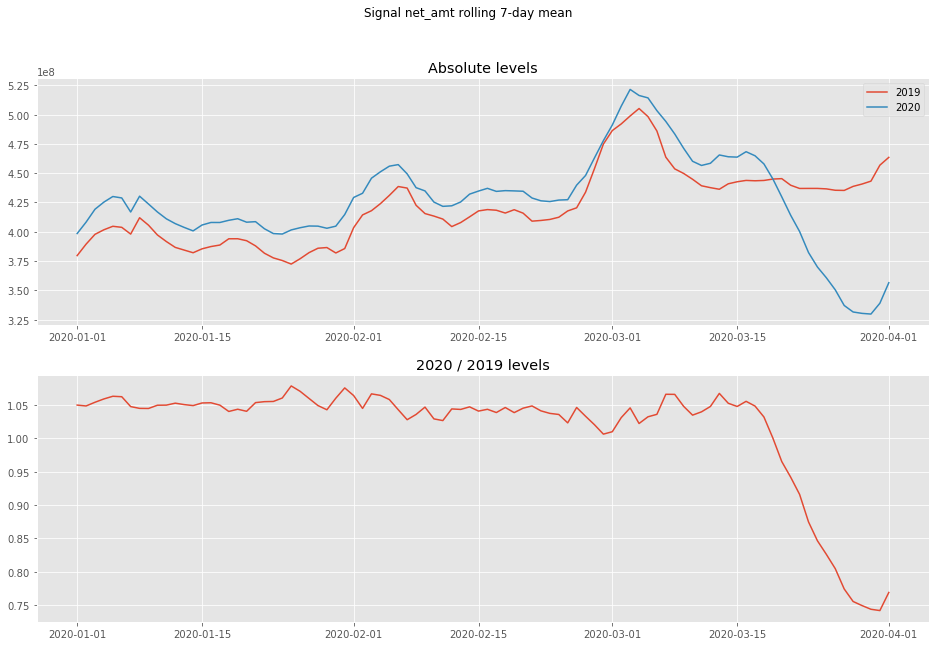

In [18]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(daily_metrics, 'net_amt'), 'Signal net_amt rolling 7-day mean')

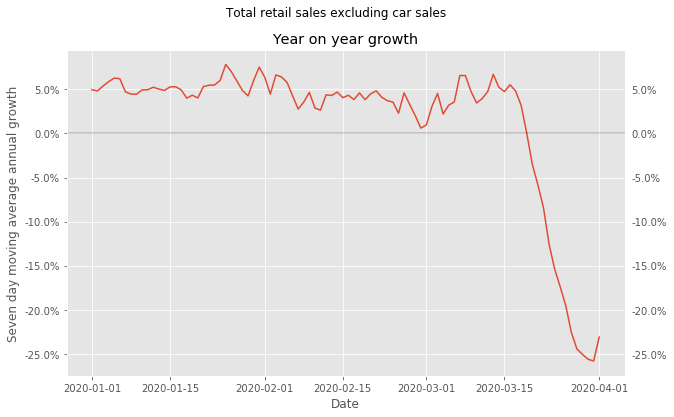

In [19]:
plot_publication(*extract_ytd_rolling_mean_comps(daily_metrics, 'net_amt'), 'Total retail sales excluding car sales', 'ex_mvpd.png')

In [20]:
ex_mvpd_raw = align_marts_with_feature_yoy_chg(marts, 'ex_mvpd_raw', daily_metrics, 'net_amt')

In [21]:
ex_mvpd_diff = diffs(ex_mvpd_raw, 'net_amt', 'ex_mvpd_raw', '2019-07')
ex_mvpd_diff

2019-07-31   -0.004420
2019-08-31   -0.013623
2019-09-30   -0.014938
2019-10-31   -0.031949
2019-11-30    0.002242
2019-12-31   -0.041099
2020-01-31    0.020329
2020-02-29    0.004443
2020-03-31         NaN
Freq: M, dtype: float64

In [22]:
error(ex_mvpd_diff, 0.9)

0.03469375580436864

In [23]:
ex_mvpd_prediction = predict_month(marts, 'ex_mvpd_raw', ex_mvpd_raw, 'net_amt', '2020-03-31')
ex_mvpd_prediction

374305.6553200447

In [24]:
ex_mvpd_prediction / marts['ex_mvpd_raw'].loc['2019-03-31'] - 1

-0.08076824481685707

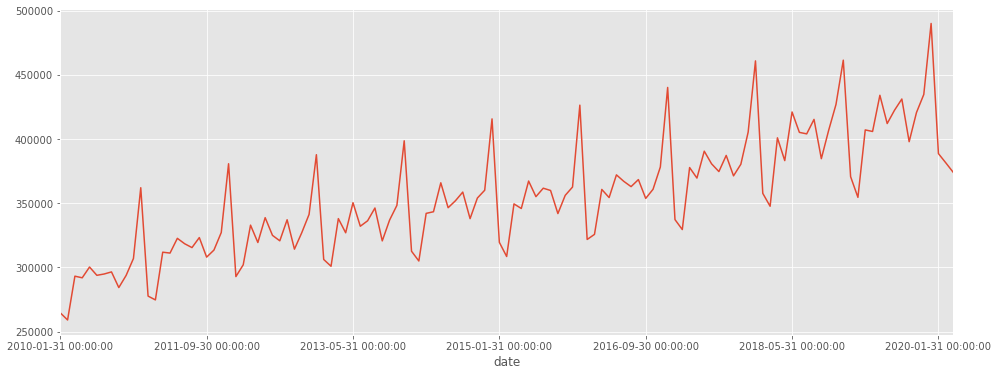

In [25]:
plot_prediction(marts, 'ex_mvpd_raw', ex_mvpd_raw, 'net_amt', '2020-03-31')

In [26]:
ex_mvpd_sa_factor = 0.99 # eyeballed it
ex_mvpd_sa = ex_mvpd_sa_factor * ex_mvpd_prediction
ex_mvpd_sa / marts['ex_mvpd_raw'].loc['2019-03-31'] - 1

-0.08996056236868855

## Food service

In [27]:
food_service_daily = daily_metrics[daily_metrics['mcc_cde'].isin(['5811', '5812', '5813', '5814'])]

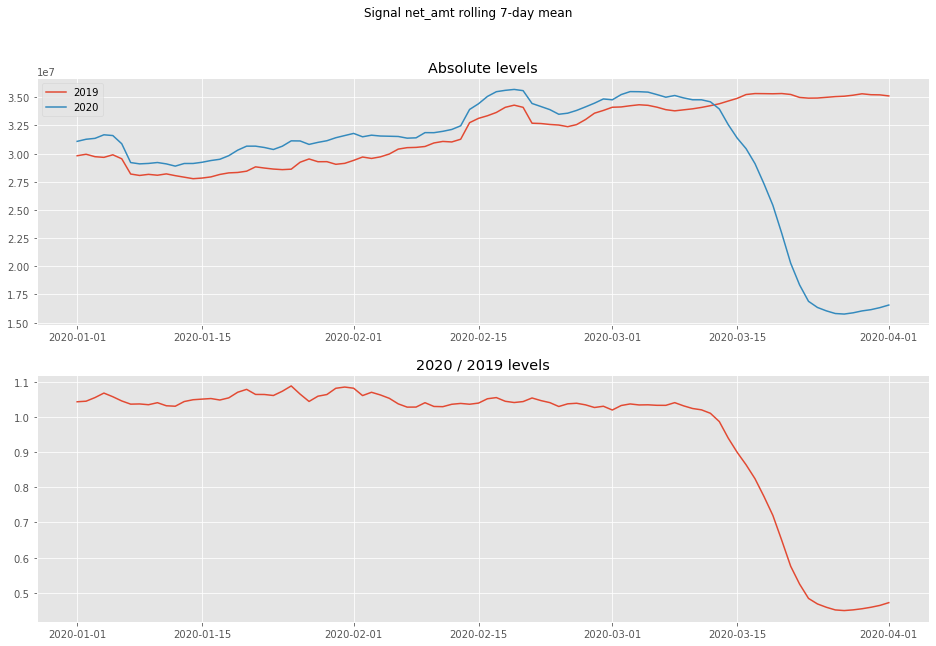

In [28]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(food_service_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

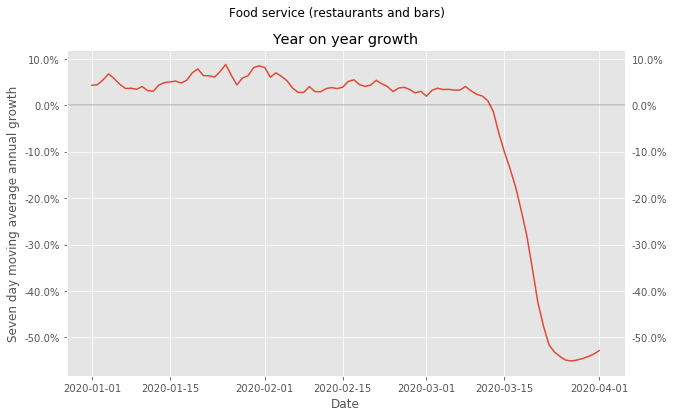

In [29]:
plot_publication(*extract_ytd_rolling_mean_comps(food_service_daily, 'net_amt'), 'Food service (restaurants and bars)', 'food_service.png')

In [30]:
food_drink_raw = align_marts_with_feature_yoy_chg(marts, 'food_drink_raw', food_service_daily, 'net_amt')

In [31]:
food_drink_diff = diffs(food_drink_raw, 'net_amt', 'food_drink_raw', '2019-07')
food_drink_diff

2019-07-31    0.020095
2019-08-31    0.018069
2019-09-30   -0.007007
2019-10-31   -0.033334
2019-11-30   -0.008009
2019-12-31   -0.037701
2020-01-31    0.000498
2020-02-29   -0.004682
2020-03-31         NaN
Freq: M, dtype: float64

In [32]:
error(food_drink_diff, 0.9)

0.034644368668416005

In [33]:
food_service_predict = predict_month(marts, 'food_drink_raw', food_drink_raw, 'net_amt', '2020-03-31')
food_service_predict

46722.30547021749

In [34]:
food_service_predict / marts['food_drink_raw'].loc['2019-03-31'] - 1

-0.2980844680275

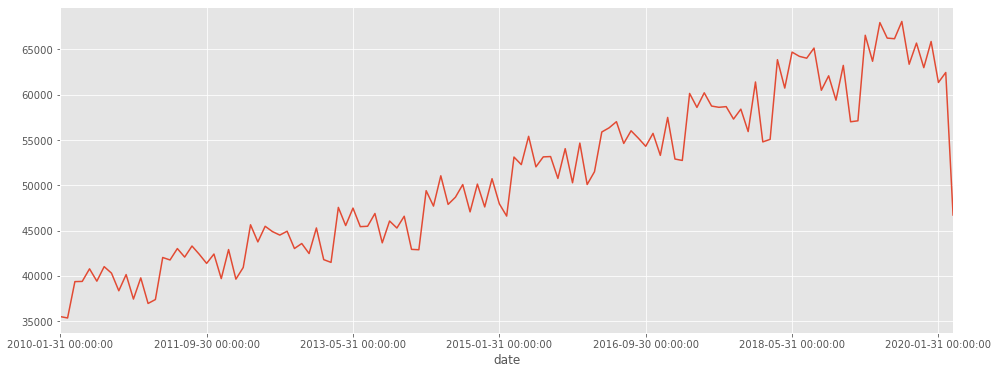

In [35]:
plot_prediction(marts, 'food_drink_raw', food_drink_raw, 'net_amt', '2020-03-31')

In [36]:
food_service_sa_factor = march_sa['Food services and drinking places']
food_service_sa = food_service_sa_factor * food_service_predict
food_service_sa / marts['food_drink_raw'].loc['2019-03-31'] - 1

-0.274219339940435

## Food and beverage stores

In [37]:
food_bev_daily = daily_metrics[(daily_metrics['mcc_cde'] >= '5411') & (daily_metrics['mcc_cde'] <= '5499')]

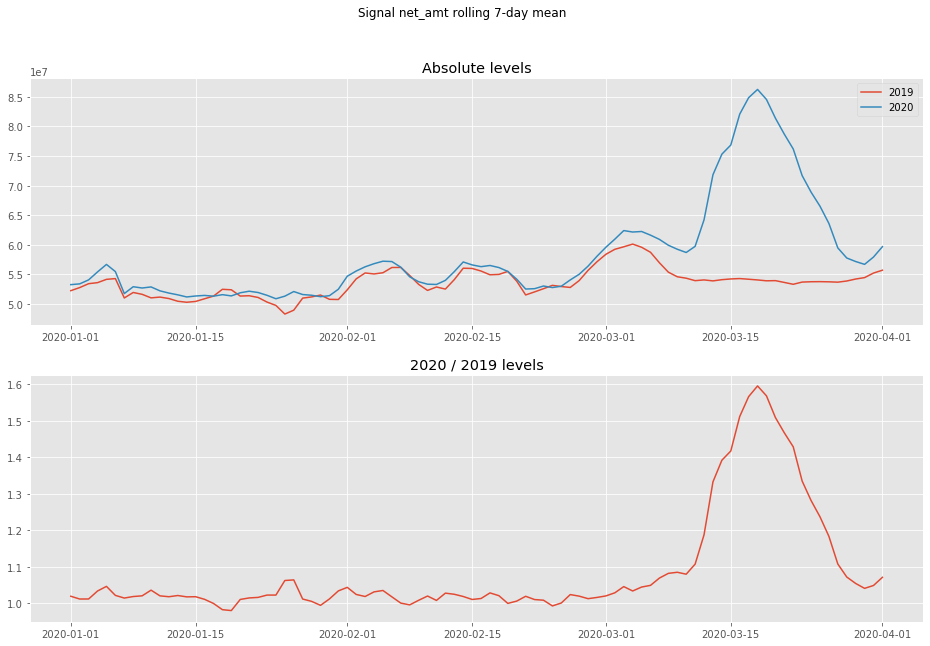

In [38]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(food_bev_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

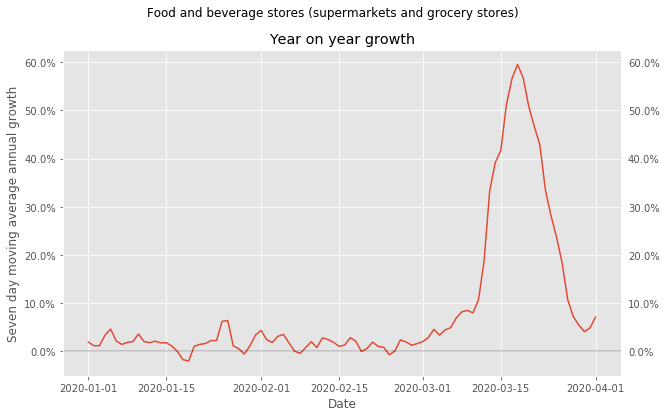

In [39]:
plot_publication(*extract_ytd_rolling_mean_comps(food_bev_daily, 'net_amt'), 'Food and beverage stores (supermarkets and grocery stores)', 'food_bev.png')

In [40]:
food_bev_raw = align_marts_with_feature_yoy_chg(marts, 'food_bev_raw', food_bev_daily, 'net_amt')

In [41]:
food_bev_diff = diffs(food_bev_raw, 'net_amt', 'food_bev_raw', '2019-07')
food_bev_diff

2019-07-31   -0.031616
2019-08-31   -0.036225
2019-09-30   -0.029194
2019-10-31   -0.038565
2019-11-30   -0.013071
2019-12-31   -0.049269
2020-01-31    0.011680
2020-02-29   -0.019206
2020-03-31         NaN
Freq: M, dtype: float64

In [42]:
error(food_bev_diff, 0.9)

0.041776626298210696

In [43]:
food_bev_predict = predict_month(marts, 'food_bev_raw', food_bev_raw, 'net_amt', '2020-03-31')
food_bev_predict

76302.32414015003

In [44]:
food_bev_predict / marts['food_bev_raw'].loc['2019-03-31'] - 1

0.19386537958677597

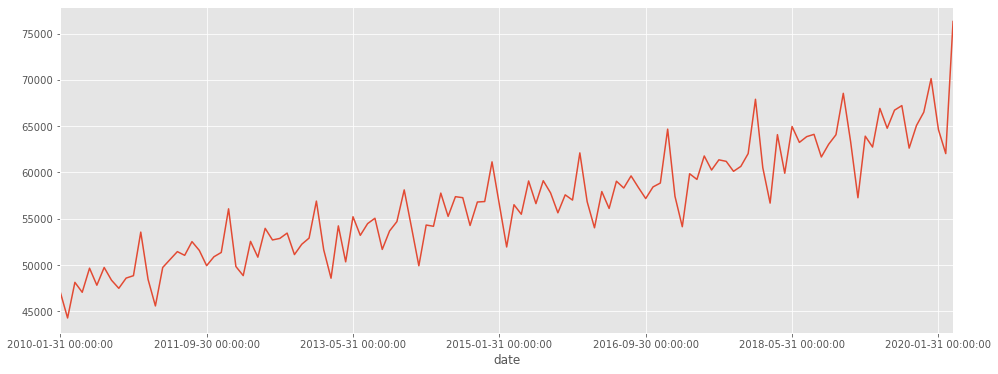

In [45]:
plot_prediction(marts, 'food_bev_raw', food_bev_raw, 'net_amt', '2020-03-31')

## General merchandise

In [46]:
gen_merch_daily = daily_metrics[(daily_metrics['mcc_cde'] >= '5300') & (daily_metrics['mcc_cde'] <= '5399')]

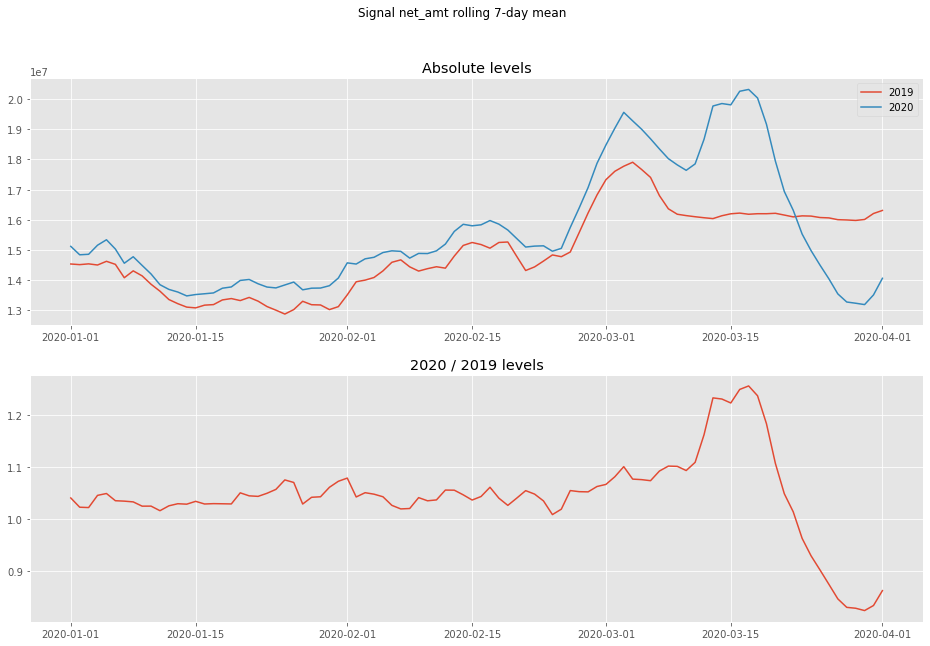

In [47]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(gen_merch_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

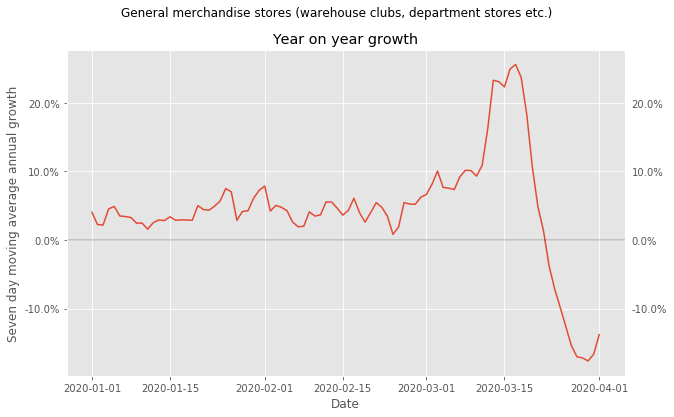

In [48]:
plot_publication(*extract_ytd_rolling_mean_comps(gen_merch_daily, 'net_amt'), 'General merchandise stores (warehouse clubs, department stores etc.)', 'gen_merch.png')

In [49]:
gen_merch_raw = align_marts_with_feature_yoy_chg(marts, 'gen_merch_raw', gen_merch_daily, 'net_amt')

In [50]:
gen_merch_diff = diffs(gen_merch_raw, 'net_amt', 'gen_merch_raw', '2019-07')
gen_merch_diff

2019-07-31   -0.030676
2019-08-31   -0.022555
2019-09-30    0.019672
2019-10-31    0.000341
2019-11-30   -0.006639
2019-12-31    0.010069
2020-01-31    0.025451
2020-02-29    0.035208
2020-03-31         NaN
Freq: M, dtype: float64

In [51]:
error(gen_merch_diff, 0.9)

0.0320352132059617

In [52]:
gen_merch_predict = predict_month(marts, 'gen_merch_raw', gen_merch_raw, 'net_amt', '2020-03-31')
gen_merch_predict

58762.264540448734

In [53]:
gen_merch_predict / marts['gen_merch_raw'].loc['2019-03-31'] - 1

0.0058414703693661085

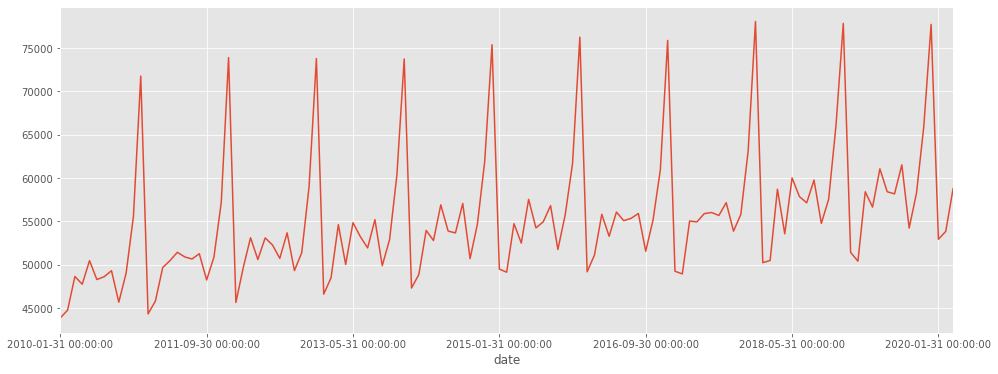

In [54]:
plot_prediction(marts, 'gen_merch_raw', gen_merch_raw, 'net_amt', '2020-03-31')

In [55]:
gen_merch_sa_factor = march_sa['General merchandise stores']
gen_merch_sa = gen_merch_sa_factor * gen_merch_predict
gen_merch_sa / marts['gen_merch_raw'].loc['2019-03-31'] - 1

-0.03137466403430056

## Nonstore retail

In [56]:
# Separate download because we have to filter by merchant_name
non_store_daily = pd.read_csv(
    'nonstore_daily.csv', 
    dtype={'MCC_CDE': str, 'NET_AMT': np.float64}
)

non_store_daily.columns = map(str.lower, non_store_daily.columns)
non_store_daily = non_store_daily.set_index(pd.to_datetime(non_store_daily['txn_date'])).drop('txn_date', axis=1)
non_store_daily = non_store_daily.sort_index()
non_store_daily

,mcc_cde,net_amt
txn_date,,
2018-01-01,5661,58065.74
2018-01-01,5999,121416.31
2018-01-01,5967,193.23
2018-01-01,5411,8852.32
2018-01-01,5733,14497.79
...,...,...
2020-04-06,5942,5395892.39
2020-04-06,5995,3513.08
2020-04-06,7399,82766.57


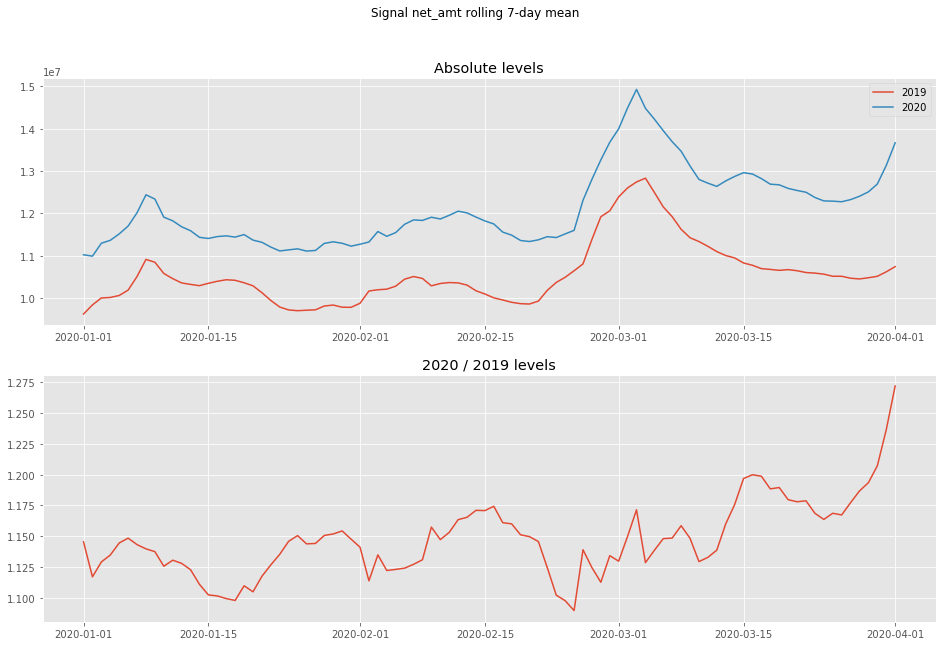

In [57]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(non_store_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

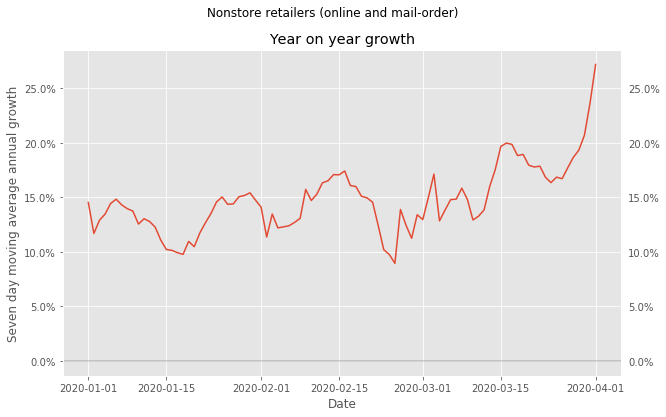

In [58]:
plot_publication(*extract_ytd_rolling_mean_comps(non_store_daily, 'net_amt'), 'Nonstore retailers (online and mail-order)', 'nonstore.png')

In [59]:
nonstore_raw = align_marts_with_feature_yoy_chg(marts, 'nonstore_raw', non_store_daily, 'net_amt')

In [60]:
nonstore_diff = diffs(nonstore_raw, 'net_amt', 'nonstore_raw', '2019-07')
nonstore_diff

2019-07-31    0.001873
2019-08-31   -0.009277
2019-09-30   -0.007846
2019-10-31    0.005086
2019-11-30   -0.019674
2019-12-31   -0.058359
2020-01-31    0.066694
2020-02-29    0.098752
2020-03-31         NaN
Freq: M, dtype: float64

In [61]:
error(nonstore_diff, 0.9)

0.07631121967112794

In [62]:
nonstore_predict = predict_month(marts, 'nonstore_raw', nonstore_raw, 'net_amt', '2020-03-31')
nonstore_predict

71096.70807642784

In [63]:
nonstore_predict / marts['nonstore_raw'].loc['2019-03-31'] - 1

0.17979337022381991

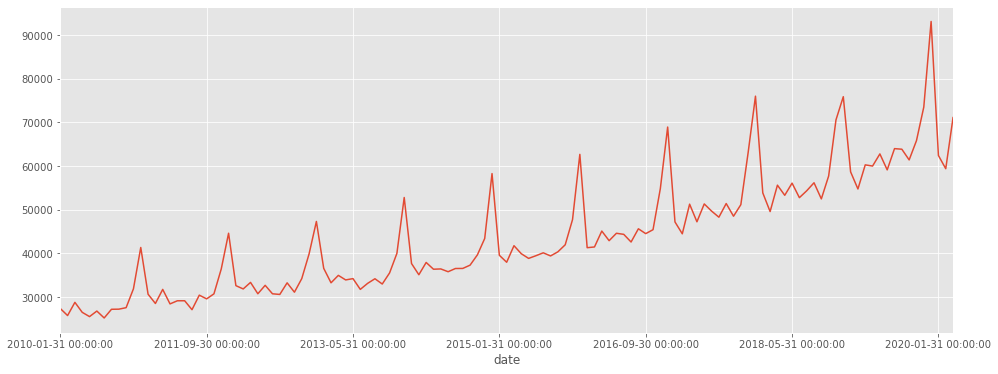

In [64]:
plot_prediction(marts, 'nonstore_raw', nonstore_raw, 'net_amt', '2020-03-31')

In [65]:
nonstore_sa_factor = march_sa['Nonstore retailers']
nonstore_sa = nonstore_sa_factor * nonstore_predict
nonstore_sa / marts['nonstore_raw'].loc['2019-03-31'] - 1

0.15619750281934364

## Building materials

In [66]:
build_daily = daily_metrics[((daily_metrics['mcc_cde'] >= '5198') & (daily_metrics['mcc_cde'] <= '5261')) | ((daily_metrics['mcc_cde'] >= '5712') & (daily_metrics['mcc_cde'] <= '5719'))]

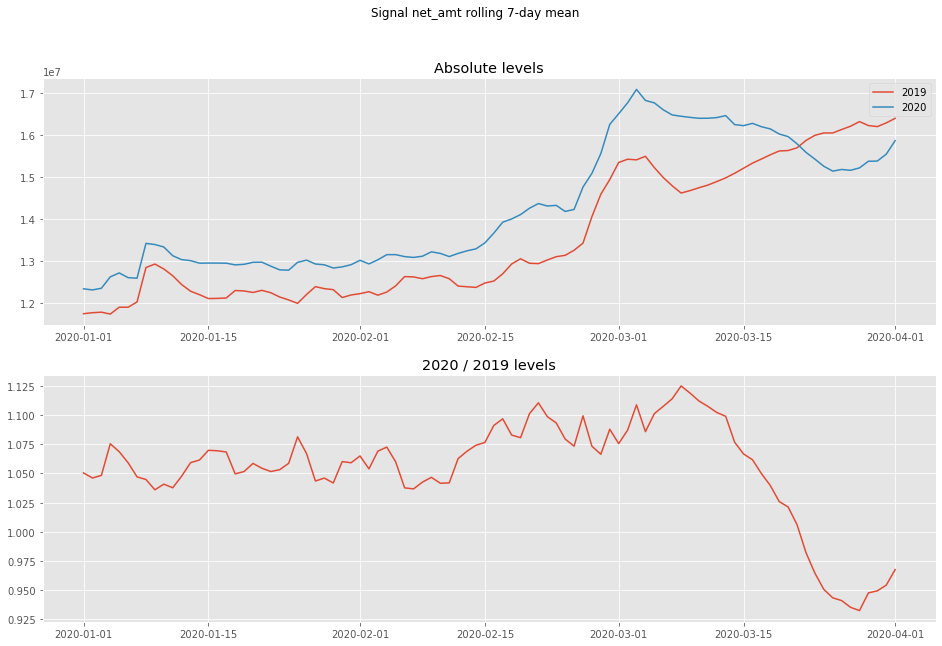

In [67]:
plot_yoy_comp(*extract_ytd_rolling_mean_comps(build_daily, 'net_amt'), 'Signal net_amt rolling 7-day mean')

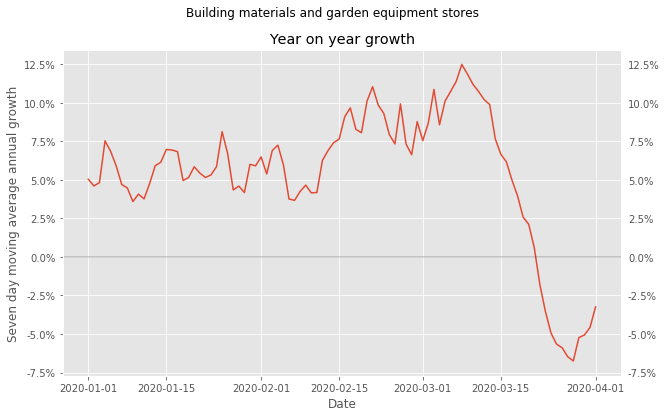

In [68]:
plot_publication(*extract_ytd_rolling_mean_comps(build_daily, 'net_amt'), 'Building materials and garden equipment stores', 'build_mat.png')

In [69]:
# Check for furniture stores, included or not?
build_raw = align_marts_with_feature_yoy_chg(marts, 'build_mat_garden_raw', build_daily, 'net_amt')

In [70]:
build_diff = diffs(build_raw, 'net_amt', 'build_mat_garden_raw', '2019-07')
build_diff

2019-07-31    0.010448
2019-08-31    0.009370
2019-09-30   -0.013592
2019-10-31    0.000497
2019-11-30    0.016065
2019-12-31   -0.016425
2020-01-31    0.052345
2020-02-29    0.052605
2020-03-31         NaN
Freq: M, dtype: float64

In [71]:
error(build_diff, 0.9)

0.052422600101634576

In [72]:
build_predict = predict_month(marts, 'build_mat_garden_raw', build_raw, 'net_amt', '2020-03-31')
build_predict

30946.437739366524

In [73]:
build_predict / marts['build_mat_garden_raw'].loc['2019-03-31'] - 1

0.01310933475304532

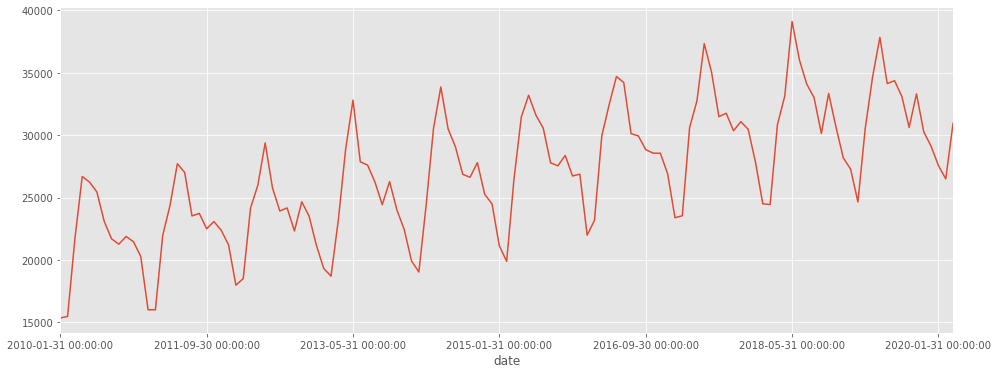

In [74]:
plot_prediction(marts, 'build_mat_garden_raw', build_raw, 'net_amt', '2020-03-31')

In [75]:
build_sa_factor = march_sa['Building mat. and garden equip. and supp. dealers']
build_sa = build_sa_factor * build_predict
build_sa / marts['build_mat_garden_raw'].loc['2019-03-31'] - 1

0.001965132070761877

# Weekly annual change

Prepare a sheet for export to Excel.

In [76]:
ex_mvpd_weekly = weekly_annual_change(daily_metrics, 'net_amt', '2020-01-12', '2020-03-29')

In [77]:
food_service_weekly = weekly_annual_change(food_service_daily, 'net_amt', '2020-01-12', '2020-03-29')

In [78]:
food_bev_weekly = weekly_annual_change(food_bev_daily, 'net_amt', '2020-01-12', '2020-03-29')

In [79]:
gen_merch_weekly = weekly_annual_change(gen_merch_daily, 'net_amt', '2020-01-12', '2020-03-29')

In [80]:
nonstore_weekly = weekly_annual_change(non_store_daily, 'net_amt', '2020-01-12', '2020-03-29')

In [81]:
build_weekly = weekly_annual_change(build_daily, 'net_amt', '2020-01-12', '2020-03-29')

In [82]:
weekly = pd.DataFrame([
    ex_mvpd_weekly, 
    food_service_weekly, 
    food_bev_weekly, 
    gen_merch_weekly, 
    nonstore_weekly,
    build_weekly]).T

weekly.columns = [
    'Retail and food service', 
    'Food service', 
    'Food and beverage stores', 
    'General merchandise stores',
    'Nonstore retailers',
    'Building materials and garden equipment stores']

weekly

,Retail and food service,Food service,Food and beverage stores,General merchandise stores,Nonstore retailers,Building materials and garden equipment stores
txn_date,,,,,,
2020-01-12,0.058742,0.035102,0.027434,0.035876,0.131715,0.061122
2020-01-19,0.047847,0.065593,0.000504,0.033986,0.117500,0.054656
2020-01-26,0.055649,0.054053,0.021767,0.048018,0.142607,0.050905
2020-02-02,0.035605,0.064949,0.005912,0.038149,0.110500,0.061017
2020-02-09,0.052018,0.029645,0.028078,0.035206,0.151173,0.044544
2020-02-16,0.044684,0.042203,0.024994,0.051547,0.180266,0.076269
2020-02-23,0.032454,0.041978,-0.002111,0.020414,0.089359,0.090456
2020-03-01,-0.001872,0.018558,0.005968,0.049567,0.110709,0.070114
2020-03-08,0.074934,0.037524,0.097512,0.114048,0.178793,0.120610


In [83]:
weekly.to_csv('weekly.csv')

# Seasonal adjustments

In [84]:
sa

,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
Sector,,,,,,,,,,,,,,,,,
"Retail Sales and Food Services, total",1.132,0.905,0.878,1.010,0.989,1.057,0.996,1.017,1.039,0.950,1.000,1.020,1.129,0.910,0.909,1.000,0.994
"Retail Sales, total",1.145,0.903,0.873,1.002,0.987,1.057,0.992,1.017,1.038,0.947,0.999,1.027,1.148,0.907,0.904,0.993,0.991
Motor vehicle and parts dealers,0.995,0.883,0.891,1.073,1.010,1.090,1.016,1.058,1.090,0.957,0.991,0.948,0.991,0.886,0.924,1.057,1.019
Automobile and other motor vehicle dealers,1.000,0.877,0.892,1.077,1.010,1.093,1.016,1.059,1.093,0.956,0.983,0.947,0.995,0.880,0.925,1.059,1.019
"Automotive parts, acc., and tire stores",0.909,0.933,0.892,1.034,1.021,1.059,1.010,1.054,1.063,0.976,1.065,0.973,0.925,0.931,0.915,1.041,1.025
Furniture and home furnishings stores,1.137,0.907,0.874,1.007,0.946,1.022,0.970,1.009,1.048,0.988,1.008,1.092,1.135,0.913,0.904,0.997,0.953
Electronics and appliance stores,1.461,0.940,0.867,0.949,0.861,0.935,0.928,0.943,0.993,0.937,0.939,1.242,1.457,0.948,0.894,0.945,0.859
Building mat. and garden equip. and supp. dealers,0.889,0.827,0.786,0.963,1.115,1.228,1.098,1.093,1.030,0.968,1.053,0.947,0.905,0.827,0.806,0.989,1.120
Building mat. and supplies dealers,0.890,0.838,0.791,0.948,1.074,1.195,1.088,1.109,1.047,0.985,1.062,0.964,0.903,0.835,0.806,0.977,1.083
